In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import copy

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [96]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, transform = transform, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, transform = transform, download = True)

batchSize = 32
train_loader = DataLoader(trainset, batch_size = batchSize, shuffle = True, drop_last = True)
test_loader = DataLoader(testset, batch_size = testset.data.shape[0])

Files already downloaded and verified
Files already downloaded and verified


In [97]:
trainset_small = Subset(trainset, range(2000))
testset_small = Subset(testset, range(2000))
trainsmall_loader = DataLoader(trainset_small, batch_size = batchSize, shuffle = True, drop_last = True)
testsmall_loader = DataLoader(testset_small, batch_size = testset_small.dataset.data[0].shape[0])


In [98]:
print(trainset.data.shape)
print(testset.data.shape)

print(np.max(trainset.data), np.min(trainset.data))
print(train_loader.dataset.classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
255 0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [99]:
X, y = next(iter(trainsmall_loader))
print(torch.max(X.data), torch.min(X.data))
print(X.data.shape, y.data.shape)

tensor(1.) tensor(-1.)
torch.Size([32, 3, 32, 32]) torch.Size([32])


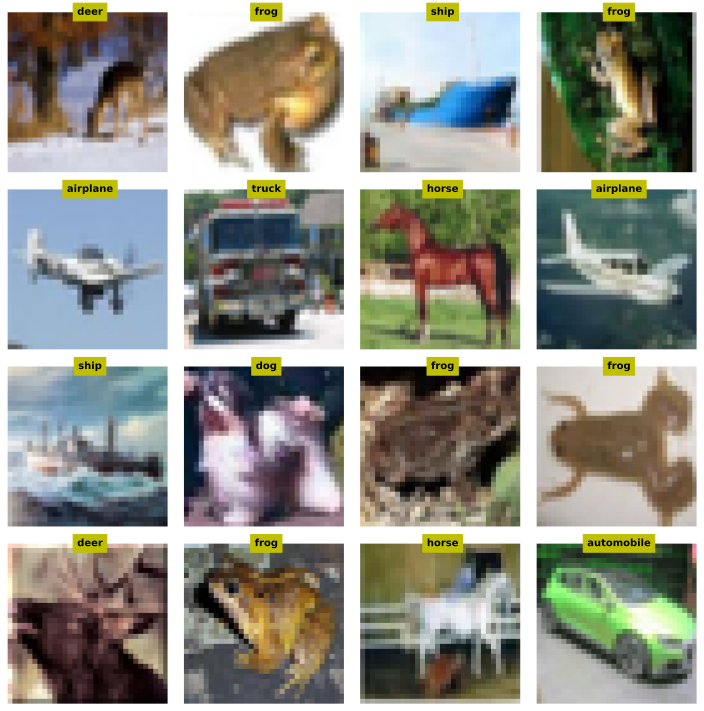

In [100]:
# inspect a few random images

X,y = next(iter(trainsmall_loader))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [101]:
def makeTheAENet(printtoggle = False):

  class AENet(nn.Module):
    def __init__(self, printtoggle):
      super().__init__()
      self.print = printtoggle

      # encoder layer
      self.encconv1 = nn.Conv2d(3, 16, 4,  padding=1, stride=2)
      # np.floor((32 + 2*1 - 4)/2) + 1 16
      self.encconv2 = nn.Conv2d(16, 32, 4, padding=1, stride=2)
      self.encconv3 = nn.Conv2d(32, 64, 4, padding=1, stride=2)

      #decoding layer
      self.decconv1 = nn.ConvTranspose2d(64, 32, 4, padding = 1, stride = 2)
      self.decconv2 = nn.ConvTranspose2d(32, 16, 4, padding = 1, stride = 2)
      self.decconv3 = nn.ConvTranspose2d(16, 3, 4, padding = 1, stride = 2)

    def forward(self, x):
      print(f'Input shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.encconv1(x))
      print(f'First encoder shape {x.shape}') if self.print else None
      
      x = F.leaky_relu(self.encconv2(x))
      print(f'second encoder shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.encconv3(x))
      print(f'third encoder shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.decconv1(x))
      print(f'First decoder shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.decconv2(x))
      print(f'Second decoder shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.decconv3(x))
      print(f'Third decoder shape {x.shape}') if self.print else None

      return x
  
  net = AENet(printtoggle)
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = .001)

  return net, lossfun, optimizer

In [102]:
X, y = next(iter(testsmall_loader))
net, lossfun, optimizer = makeTheAENet(True)
print(X.dtype)
print(X.shape)
yHat = net(X)
print(yHat.shape)
loss = lossfun(yHat, y) 
print(loss)
print(loss.dtype)

torch.float32
torch.Size([32, 3, 32, 32])
Input shape torch.Size([32, 3, 32, 32])
First encoder shape torch.Size([32, 16, 16, 16])
second encoder shape torch.Size([32, 32, 8, 8])
third encoder shape torch.Size([32, 64, 4, 4])
First decoder shape torch.Size([32, 32, 8, 8])
Second decoder shape torch.Size([32, 16, 16, 16])
Third decoder shape torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
tensor(34.3172, grad_fn=<MseLossBackward0>)
torch.float32


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [103]:
def function2TrainTheModel(net, lossfun, optimizer):
  numepochs = 10
  net.to(device)

  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)

  for epoch in range(numepochs):
    net.train()
    batchLoss = []
    for X, y in train_loader:
      X = X.to(device)
      y = y.to(device)
      yHat = net(X)
      loss = lossfun(yHat, X)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
    
    trainLoss[epoch] = np.mean(batchLoss)

    net.eval()
    X, y = next(iter(test_loader))
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)    
      loss = lossfun(yHat, X) 
    
    testLoss[epoch] = loss.item()
  
  return trainLoss, testLoss, net

In [104]:
# a function that trains the model

def function2trainTheAEModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 15
  
  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)
      
      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [105]:
AEnet, lossfun, optimizer = makeTheAENet(False)
trainLoss, testLoss, AEnet = function2TrainTheModel(AEnet, lossfun, optimizer)

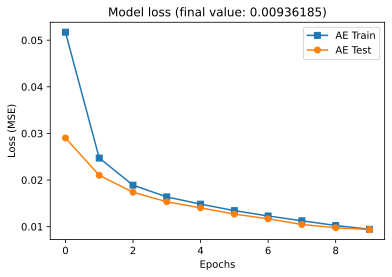

In [70]:
plt.plot(trainLoss,'s-',label='AE Train')
plt.plot(testLoss,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLoss[-1])
plt.legend()

plt.show()

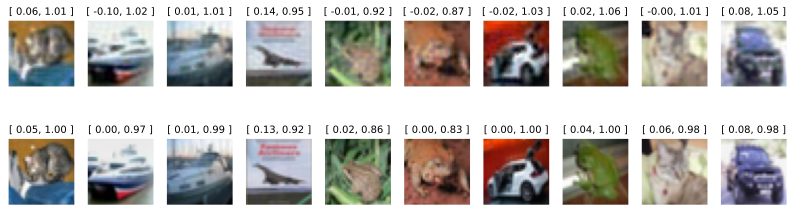

In [72]:
## show some random examples

# get some data
X,y = next(iter(testsmall_loader))

# forward pass and loss
net.cpu()
net.eval() # switch to test mode
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

  
plt.show()

In [77]:
def makeTheClassifier(printtoggle = False):
  class ClassifierNet(nn.Module):
    def __init__(self, printtoggle):
      super().__init__()
      self.print = printtoggle

      self.enconv1 = nn.Conv2d(3, 16, 4, padding = 1, stride = 2)
      self.enconv2 = nn.Conv2d(16, 32, 4, padding = 1, stride = 2)
      self.enconv3 = nn.Conv2d(32, 64, 4, padding = 1, stride = 2)

      self.fc1 = nn.Linear(4*4*64, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
      print(f'Input shape: {x.shape}') if self.print else None
      x = F.leaky_relu(self.enconv1(x))
      print(f'First encoding layer shape: {x.shape}') if self.print else None

      x = F.leaky_relu(self.enconv2(x))
      print(f'Second encoding layer shape: {x.shape}') if self.print else None

      x = F.leaky_relu(self.enconv3(x))
      print(f'Third encoding layer shape: {x.shape}') if self.print else None

      print(x.shape, x.shape.numel()) if self.print else None
      nUnits = (x.shape.numel())/ x.shape[0]
      x = x.view(-1, int(nUnits))
      print(f'Vectorized shape {x.shape}') if self.print else None

      x = F.leaky_relu(self.fc1(x))
      print(f'First linear layer shape: {x.shape}') if self.print else None

      x = F.leaky_relu(self.fc2(x))
      print(f'Second linear layer shape: {x.shape}') if self.print else None

      x = F.leaky_relu(self.fc3(x))
      print(f'Third linear layer shape: {x.shape}') if self.print else None

      return x
  
  net = ClassifierNet(printtoggle)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr = .001)

  return net, lossfun, optimizer




In [81]:
net, lossfun, optimizer = makeTheClassifier(True)
X, y = next(iter(testsmall_loader))
yHat = net(X)
loss = lossfun(yHat, y)
print(yHat.shape,yHat[0], loss)

Input shape: torch.Size([32, 3, 32, 32])
First encoding layer shape: torch.Size([32, 16, 16, 16])
Second encoding layer shape: torch.Size([32, 32, 8, 8])
Third encoding layer shape: torch.Size([32, 64, 4, 4])
torch.Size([32, 64, 4, 4]) 32768
Vectorized shape torch.Size([32, 1024])
First linear layer shape: torch.Size([32, 128])
Second linear layer shape: torch.Size([32, 64])
Third linear layer shape: torch.Size([32, 10])
torch.Size([32, 10]) tensor([-0.0002,  0.0677,  0.0772, -0.0007, -0.0005, -0.0012,  0.0311,  0.0060,
         0.0298, -0.0002], grad_fn=<SelectBackward0>) tensor(2.3074, grad_fn=<NllLossBackward0>)


In [88]:
def function2TrainTheClassifier(net, lossfun, optimizer):
  numepochs = 10
  net.to(device)
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)


  for epochi in range(numepochs):
    net.train()
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:
      X = X.to(device)
      y = y.to(device)
      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      batchLoss.append(loss.item())

      matches = (torch.argmax(yHat, axis = 1) == y).float()
      accuracy = torch.mean(matches)
      batchAcc.append(100 * accuracy.item())

    
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    net.eval()
    X, y = next(iter(test_loader))
    X = X.to(device)
    y = y.to(device)


    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat, y)
    
    testLoss[epochi] = loss.item()
    testAcc[epochi] = (100* torch.mean((torch.argmax(yHat,axis=1) == y).float()).item())
  
  return trainAcc, trainLoss, testAcc, testLoss, net


In [89]:
net, lossfun, optimizer = makeTheClassifier(False)
trainAcc, trainLoss, testAcc, testLoss, net = function2TrainTheClassifier(net, lossfun, optimizer)

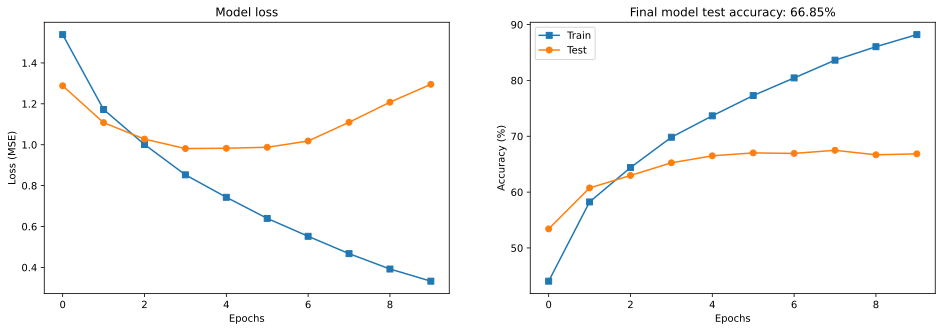

In [90]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [112]:
X, y = next(iter(AEnet.named_parameters()))
print(X, y)
if 'enc' in X:
  print(True)

encconv1.weight Parameter containing:
tensor([[[[ 3.6147e-02, -1.3871e-01, -8.3135e-03, -5.2117e-02],
          [ 6.8928e-02, -2.4047e-01, -2.1566e-01, -1.2871e-01],
          [-1.6215e-01, -2.4407e-01, -7.8250e-02, -2.2108e-01],
          [-2.8253e-02, -7.4002e-02,  4.0477e-02, -3.5433e-02]],

         [[ 1.8550e-02, -9.5495e-02, -1.1177e-02, -1.1854e-01],
          [-1.3402e-01, -1.1306e-01, -1.8826e-01, -1.7739e-01],
          [-1.8758e-01, -2.0309e-01, -1.0388e-01, -1.8218e-01],
          [ 4.4647e-02, -2.8635e-01, -1.6354e-01, -1.6594e-01]],

         [[ 2.8290e-02,  1.5091e-01,  8.4559e-02,  5.0101e-02],
          [ 1.3307e-01, -1.2165e-01,  1.5527e-01,  1.7896e-01],
          [ 6.6652e-02, -1.4380e-01,  6.5479e-03, -8.1209e-02],
          [ 1.6510e-01, -1.4332e-02,  5.9101e-02,  1.4389e-01]]],


        [[[ 9.9550e-03,  1.9101e-01,  6.7008e-02, -4.8163e-02],
          [ 2.4365e-01,  5.9532e-01,  4.4874e-01,  1.5213e-01],
          [ 6.2919e-02,  3.6522e-01,  2.7617e-01, -1.1250e

In [115]:
# create a new network (weights replaced below)
pretrainNet,lossfun,optimizer = makeTheClassifier()


#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet.named_parameters(),AEnet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])
  
  if 'enc' in target[0]:
    
    # copy over the parameters...
    target[1].data = copy.deepcopy( source[1].data )
    
    # ...and then freeze that layer
    target[1].requires_grad = False

    print('Weights copied')

PRETRAIN: enconv1.weight  AENET: encconv1.weight
Weights copied
PRETRAIN: enconv1.bias  AENET: encconv1.bias
Weights copied
PRETRAIN: enconv2.weight  AENET: encconv2.weight
Weights copied
PRETRAIN: enconv2.bias  AENET: encconv2.bias
Weights copied
PRETRAIN: enconv3.weight  AENET: encconv3.weight
Weights copied
PRETRAIN: enconv3.bias  AENET: encconv3.bias
Weights copied
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias
PRETRAIN: fc3.weight  AENET: decconv3.weight
PRETRAIN: fc3.bias  AENET: decconv3.bias


In [116]:
trainAcc, trainLoss, testAcc, testLoss, net = function2TrainTheClassifier(pretrainNet, lossfun, optimizer)

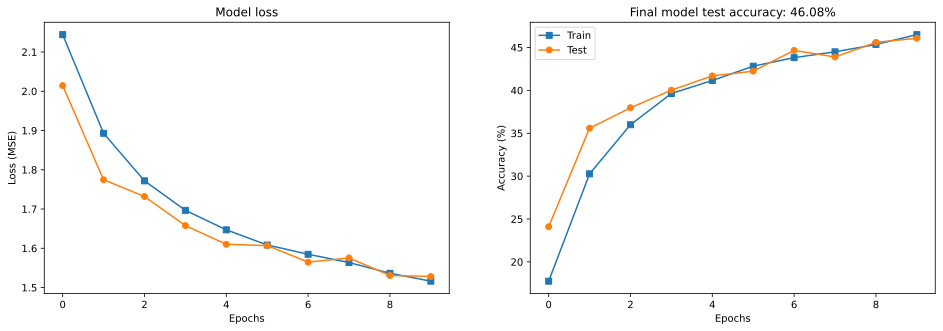

In [117]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [118]:
# create a new network (weights replaced below)
pretrainNet1,lossfun,optimizer = makeTheClassifier()


#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet1.named_parameters(),AEnet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])
  
  if 'enc' in target[0]:
    
    # copy over the parameters...
    target[1].data = copy.deepcopy( source[1].data )
    
    # ...and then freeze that layer
    #target[1].requires_grad = False

    print('Weights copied')

PRETRAIN: enconv1.weight  AENET: encconv1.weight
Weights copied
PRETRAIN: enconv1.bias  AENET: encconv1.bias
Weights copied
PRETRAIN: enconv2.weight  AENET: encconv2.weight
Weights copied
PRETRAIN: enconv2.bias  AENET: encconv2.bias
Weights copied
PRETRAIN: enconv3.weight  AENET: encconv3.weight
Weights copied
PRETRAIN: enconv3.bias  AENET: encconv3.bias
Weights copied
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias
PRETRAIN: fc3.weight  AENET: decconv3.weight
PRETRAIN: fc3.bias  AENET: decconv3.bias


In [119]:
trainAcc, trainLoss, testAcc, testLoss, net = function2TrainTheClassifier(pretrainNet1, lossfun, optimizer)

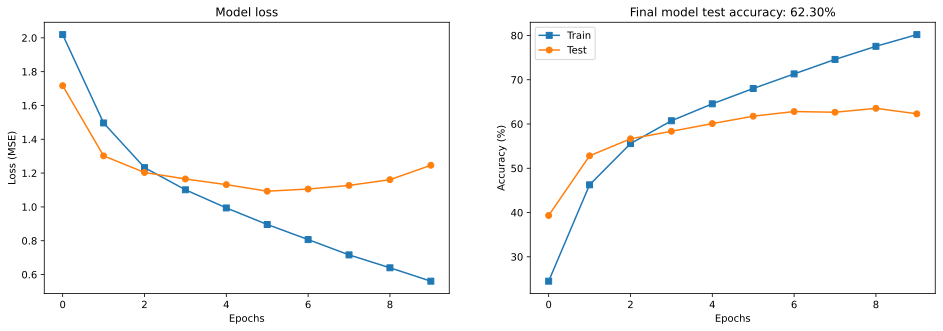

In [120]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()